In [19]:
import pandas as pd
import seaborn as sns

import openai
import asyncio
import os 
import re 
import time
import json 
import random 

from typing import Any
from synthetic_data.utils import load_attributes
from essentials.utils import (
    load_env_variable,
    init_default_parser
)

ImportError: cannot import name 'init_default_parser' from 'essentials.utils' (/Users/manuelbolz/Documents/git/for_fun/NLPSharedTask/essentials/utils.py)

In [6]:
# Data paths
ABSTRACTS = 'https://raw.githubusercontent.com/ZurichNLP/sdg_swisstext_2024_sharedtask/main/data/task1_train.jsonl'
GOALS = 'https://raw.githubusercontent.com/datapopalliance/SDGs/master/SDG-goals.csv'

In [7]:
# Functions

def read_data(path: str, format : str = 'jsonl') -> pd.DataFrame:
    """Reads training data from github."""
    if format == 'jsonl':
        return pd.read_json(path, lines=True)
    elif format == 'csv':
        return pd.read_csv(path)
    else:
        raise TypeError

In [23]:
# Read in raw data
abstract_df = read_data(ABSTRACTS) 
goals_df = read_data(GOALS, format='csv').rename(columns={'goal': 'SDG', 'description': 'DESC'})

# Merge DataFrames to working data
df = abstract_df.merge(goals_df, on='SDG', how='left')
df.loc[df.DESC.isna(), 'DESC'] = 'no_sdg'

/Users/manuelbolz/opt/anaconda3/envs/shared_task_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ABSTRACT', ylabel='Count'>

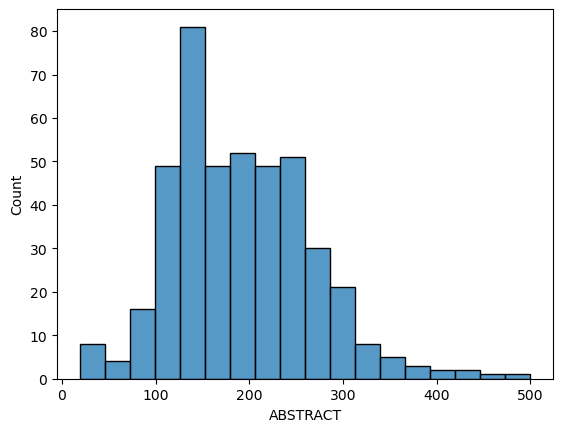

In [20]:
# Display distribution of words per abstract
sns.histplot(df['ABSTRACT'].str.split().str.len())

In [ ]:
#### Helper functions

def process_attributes(attr_name: str, label_names: list[str]) -> dict:
    if 'subtopics' in attr_name:
        return json.load(open(f"synthetic_data/raw_data/attributes/subtopics/subtopics.json", "r"))
    else:
        return load_attributes(attr_name=attr_name, classes=label_names)


def prepare_prompt(labels, sdg_goal, subtopic, length, style):

    if sdg_goal == 'no_sdg':
        first_condition = "the paper should not be related to any UN SDG goal"
    else:
        first_condition = f"the paper has to be related to the UN SDG goal of {sdg_goal};"

    return f"""
                Write an abstract of a {labels} paper on Web of Science, following the requirements below: \n
                    1. {first_condition} \n
                    2. the paper abstract should focus on '{subtopic}'; \n
                    3. should be in length between {length} words and {int(length) + 60} words; \n
                    4. the style of the paper should be '{style}'
            """


def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\"\']", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()


def save_generated_examples(output_dir: str, sdg_id: int, results: list[dict], i: int, attempt: int, top_p: float):
    prefix = f"gen_examples/sdg_goal_{sdg_id}/train_p{top_p}_{i}_{attempt}.jsonl"
    os.makedirs(f"{output_dir}/gen_examples/sdg_goal_{sdg_id}", exist_ok=True)
    with open(f"{output_dir}/{prefix}", 'w') as f:
        for example in results:
            f.write(json.dumps(example) + "\n")


#### Async functions

async def dispatch_openai_requests(
    messages_list: list[list[dict[str, Any]]],
    model: str,
    temperature: float,
    max_tokens: int,
    top_p: float,
) -> list[str]:
    """Dispatches requests to OpenAI API asynchronously.
    
    Args:
        messages_list: List of messages to be sent to OpenAI ChatCompletion API.
        model: OpenAI model to use.
        temperature: Temperature to use for the model.
        max_tokens: Maximum number of tokens to generate.
        top_p: Top p to use for the model.
    Returns:
        List of responses from OpenAI API.
    """
    async_responses = [
        openai.ChatCompletion.acreate(
            model=model,
            messages=x,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
        )
        for x in messages_list
    ]
    return await asyncio.gather(*async_responses)


def call_api_async(msg_lst, model, temperature, max_tokens):
    print("===================================")
    print(f"call APIs, {len(msg_lst)} in total, temp={temperature}.")
    l = len(msg_lst)

    response = asyncio.run(
        dispatch_openai_requests(
            messages_list = msg_lst,
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=1.0,
        )
    )

    ans = [x['choices'][0]['message']['content'] for x in response]
    print(f"API returns {len(ans)} in total.")
    print("===================================")
    return ans 

In [ ]:
def main(args):
    # Read in raw data
    abstract_df = read_data(ABSTRACTS) 
    goals_df = read_data(GOALS, format='csv').rename(columns={'goal': 'SDG', 'description': 'DESC'})

    # Merge DataFrames to working data
    df = abstract_df.merge(goals_df, on='SDG', how='left')
    df.loc[df.DESC.isna(), 'DESC'] = 'no_sdg'

    label2id = dict(zip(df['DESC'].unique(), df['SDG'].unique()))
    # id2label = {v: k for k, v in label2id.items()}

    sdg_names = list(label2id.keys())
    print(sdg_names)

    model = args.model_name
    openai.api_key = args.api_key

    attr_dict = {attr: process_attributes(attr, sdg_names) for attr in args.attributes}

    for i, sdg_goal in enumerate(sdg_names):

        print(f"SDG Goal {i}: {sdg_goal}.")

        sent_cnt = 0
        attempt = 0
        prompt_list = []  # To send prompts in batches
        prompt_attributes = []  # To store attributes of the prompt used
        results = []  # To store 

        random.seed(i + 1234)

        while sent_cnt < args.n_sample:
            
            main_topic = random.sample(list(attr_dict['subtopics'].keys()), 1)[0]
            sub_topic = random.sample(attr_dict['subtopics'][main_topic], 1)[0]

            style = random.sample(attr_dict["style"], 1)[0]
            length = random.sample(attr_dict["length"], 1)[0]

            attributes_dict = {'sdg_goal': sdg_goal,
                               'main_topic': main_topic,
                               'sub_topic': sub_topic,
                               'style': style,
                               'length': length}

            prompt_attributes.append(attributes_dict)
            
            prompt = prepare_prompt(main_topic,
                                          sub_topic,
                                          length,
                                          style)

            prompt_list.append([{"role": "user", "content": prompt}])

            if len(prompt_list) == args.batch_size:
                try:
                    attempt += 1
                    return_msg = call_api_async(prompt_list, model, args.temperature, args.max_tokens)

                    assert len(return_msg) == len(prompt_attributes)

                    valid = 0
                    examples = []
                    for (msg, attr) in zip(return_msg, prompt_attributes):
                        if any(word in msg for word in ["I apologize", "sorry", "an AI language model"]):  # invalid contents
                            continue
                        else:
                            valid += 1
                            example = {"text": clean_str(msg)}
                            example.update(attr)
                            results.append(example)

                    sent_cnt += valid 
                    prompt_list = []
                    prompt_attributes = []

                    sdg_id = label2id[sdg_goal]
                    save_generated_examples(args.output_dir, sdg_id, examples, i, attempt, args.top_p)

                except openai.error.RateLimitError:
                    print("Rate Limit Error! Attempt:", attempt)
                    prompt_list = []
                    prompt_attributes = []
                    time.sleep(10)
                    continue
                except  openai.error.APIError:
                    print("API Error! Attempt:", attempt)
                    prompt_list = []
                    prompt_attributes = []
                    time.sleep(5)
                    continue
                except openai.error.APIConnectionError:
                    print("APIConnectionError", attempt)
                    prompt_list = []
                    prompt_attributes = []
                    time.sleep(5)
                    continue 
                except openai.error.InvalidRequestError:
                    print("API Error! Invalid Request:", attempt)
                    prompt_list = []
                    prompt_attributes = []
                    continue

            if sent_cnt > args.n_sample or attempt >= 5:
                break

In [ ]:
def main(args):

    label_names, id2label = load_labels_and_mapping("synthetic_data/raw_data/label.txt")
    print(label_names)

    model = args.model_name
    openai.api_key = args.api_key

    attr_dict = {attr: process_attributes(attr, label_names) for attr in args.attributes}
    for attr, value in attr_dict.items():
        print(attr, len(value))

    for i, subtopic in enumerate(attr_dict['subtopics']):
        print(f"Subclass {i}: {subtopic}.")
        sent_cnt = 0
        attempt = 0
        prompt_lst = []
        attr_lst = []
        examples = []

        random.seed(i + 1234)
        while sent_cnt < args.n_sample:
            
            subtopic_dict = attr_dict['subtopics'][subtopic]
            labels = subtopic_dict["lbl"]

            style = random.sample(attr_dict["style"], 1)[0]
            length = random.sample(attr_dict["length"], 1)[0]
            technique = [random.sample(attr_dict["technique"][x], 1)[0] for x in labels]
            random.shuffle(technique)
            random.shuffle(labels)
            attr_lst.append(subtopic_dict)

            prompt_input = prepare_prompt(labels,
                                          subtopic,
                                          length,
                                          technique,
                                          style,
                                          kind='attribute_only')

            if i % 200 == 0 and attempt == 0:
                print(prompt_input)

            label_ids = [id2label[x] for x in labels] # topic id

            prompt_lst.append([{"role": "user", "content": prompt_input}])

            if len(prompt_lst) == args.batch_size:
                try:
                    attempt += 1
                    return_msg = call_api_async(prompt_lst, model, args.temperature, args.max_tokens)

                    assert len(return_msg) == len(attr_lst)

                    valid = 0
                    examples = []
                    for (msg, attr) in zip(return_msg, attr_lst):
                        if any(word in msg for word in ["I apologize", "sorry", "an AI language model"]):  # invalid contents
                            continue
                        else:
                            valid += 1
                            example = {"_id": label_ids, "label": labels, "text": clean_str(msg)}
                            example.update(attr)
                            examples.append(example)

                    sent_cnt += valid 
                    prompt_lst = []
                    attr_lst = []

                    save_generated_examples(args.output_dir, subtopic, examples, i, attempt, args.top_p)

                except openai.error.RateLimitError:
                    print("Rate Limit Error! Attempt:", attempt)
                    prompt_lst = []
                    attr_lst = []
                    time.sleep(10)
                    continue
                except  openai.error.APIError:
                    print("API Error! Attempt:", attempt)
                    prompt_lst = []
                    attr_lst = []
                    time.sleep(5)
                    continue
                except openai.error.APIConnectionError:
                    print("APIConnectionError", attempt)
                    prompt_lst = []
                    attr_lst = []
                    time.sleep(5)
                    continue 
                except openai.error.InvalidRequestError:
                    print("API Error! Invalid Request:", attempt)
                    prompt_lst = []
                    attr_lst = []
                    continue

            if sent_cnt > args.n_sample or attempt >= 20:
                break

In [ ]:
if __name__ == '__main__':
    
    # Init parser and add arguments
    parser = init_default_parser()
    args = parser.parse_args()
    
    args.api_key = load_env_variable(variable_name='OPENAI_API_KEY')
    args.domain = 'scientific paper'
    args.attributes = ["length", "subtopics", "style"]
    args.metadata = ""

    main(args)